<a href="https://colab.research.google.com/github/kt1156/Chest-X-Rays-CNN/blob/main/ChestXrays_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# imports + setup

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import files

 # Authenticate api token
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:29<00:00, 180MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.7MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [ ]:
!ls /content/chest_xray

# Move contents to outer folder
!mv /content/chest_xray/chest_xray/* /content/chest_xray/

# Remove any old __MACOSX folder
!rm -rf /content/chest_xray/__MACOSX

# Check
!ls /content/chest_xray

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data transforms - preprocessing
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# load set and split
from torch.utils.data import random_split

full_dataset = datasets.ImageFolder("/content/chest_xray/train", transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_data, val_data = random_split(full_dataset, [train_size, val_size])

# Load datasets
test_data = datasets.ImageFolder("/content/chest_xray/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("Batches -> Train:", len(train_loader), " Val:", len(val_loader), " Test:", len(test_loader))

Using device: cuda
Batches -> Train: 131  Val: 33  Test: 20


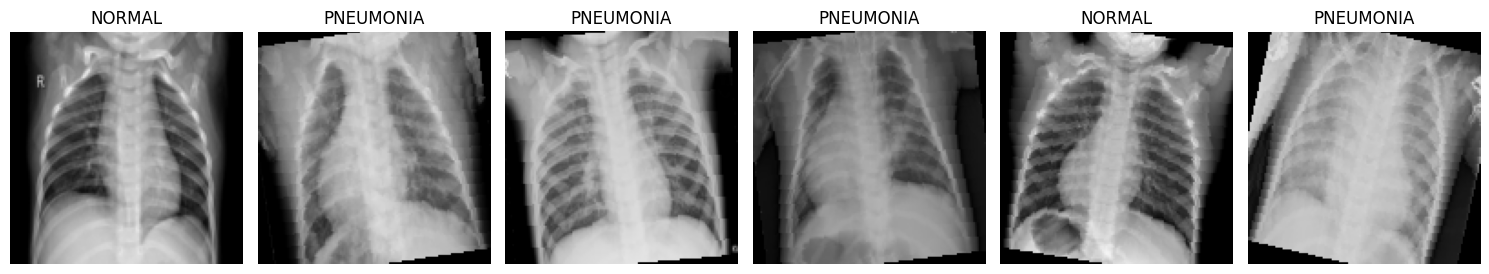

In [23]:
import matplotlib.pyplot as plt

# Grab a few samples from DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

images = images[:6]  # Show first 6 images
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
images = images * std + mean  # undo normalization

# Plot
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, ax in enumerate(axes):
    img = images[i].permute(1, 2, 0)  # C,H,W -> H,W,C
    ax.imshow(img)
    ax.set_title(train_loader.dataset.dataset.classes[labels[i]])
    ax.axis("off")
plt.tight_layout()

In [38]:
# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

class XRAYCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(XRAYCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16, 128),  # 128 -> 64 -> 32 -> 16 / 3 pools
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XRAYCNN(num_classes=len(train_data.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training Loop
epochs = 30
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs = epochs)

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_corrects.double() / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_loss_epoch = val_loss / len(val_loader.dataset)
    val_acc_epoch  = val_corrects.double() / len(val_loader.dataset)

    # Append metrics for graph

    train_losses.append(epoch_loss)
    val_losses.append(val_loss_epoch)
    train_accs.append(epoch_acc.item())
    val_accs.append(val_acc_epoch.item())

    # Scheduler
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")


# Test Evaluation
model.eval()
test_loss, test_corrects = 0.0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/30 | Train Loss: 0.3956, Train Acc: 0.8162 | Val Loss: 0.3191, Val Acc: 0.8372
Epoch 2/30 | Train Loss: 0.2228, Train Acc: 0.9077 | Val Loss: 0.2378, Val Acc: 0.9042
Epoch 3/30 | Train Loss: 0.1938, Train Acc: 0.9240 | Val Loss: 0.1959, Val Acc: 0.9186
Epoch 4/30 | Train Loss: 0.1904, Train Acc: 0.9231 | Val Loss: 0.2286, Val Acc: 0.8975
Epoch 5/30 | Train Loss: 0.1966, Train Acc: 0.9202 | Val Loss: 0.2851, Val Acc: 0.8822
Epoch 6/30 | Train Loss: 0.1833, Train Acc: 0.9274 | Val Loss: 0.1419, Val Acc: 0.9464
Epoch 7/30 | Train Loss: 0.1735, Train Acc: 0.9334 | Val Loss: 0.1578, Val Acc: 0.9330
Epoch 8/30 | Train Loss: 0.1448, Train Acc: 0.9489 | Val Loss: 0.1299, Val Acc: 0.9502
Epoch 9/30 | Train Loss: 0.1448, Train Acc: 0.9465 | Val Loss: 0.2411, Val Acc: 0.9291
Epoch 10/30 | Train Loss: 0.1377, Train Acc: 0.9545 | Val Loss: 0.1116, Val Acc: 0.9626
Epoch 11/30 | Train Loss: 0.1356, Train Acc: 0.9523 | Val Loss: 0.1207, Val Acc: 0.9531
Epoch 12/30 | Train Loss: 0.1356, Train A

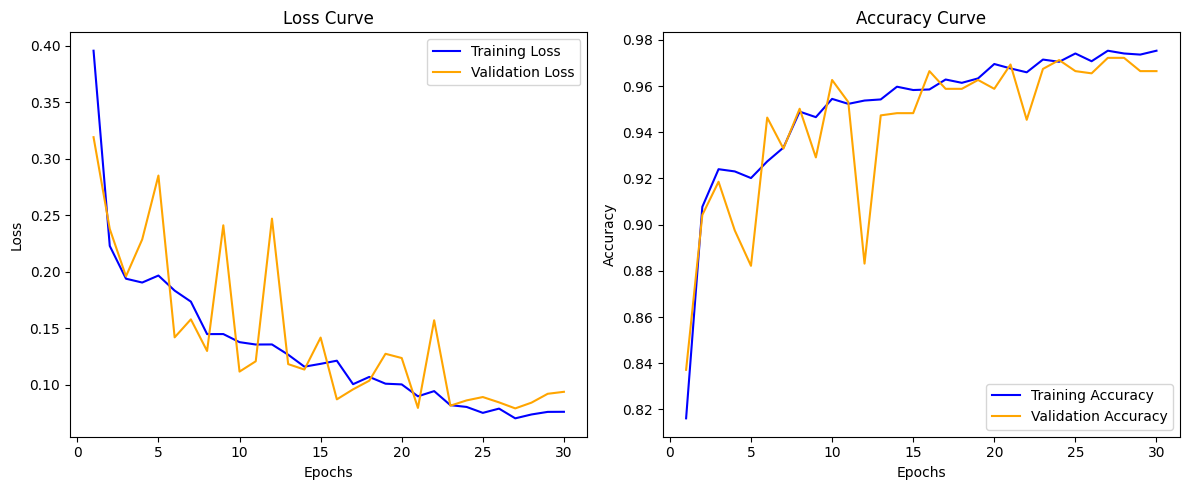

In [40]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, color='blue', label='Training Loss')
plt.plot(epochs, val_losses, color='orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, color='blue', label='Training Accuracy')
plt.plot(epochs, val_accs, color='orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

      NORMAL       0.97      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.85      0.81      0.79       624



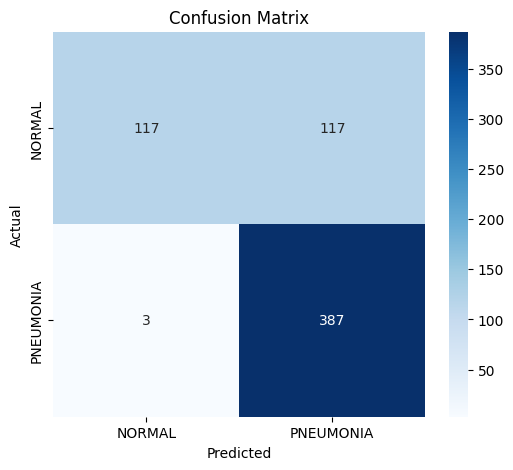

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
target_names = test_loader.dataset.classes  # ['NORMAL', 'PNEUMONIA']
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


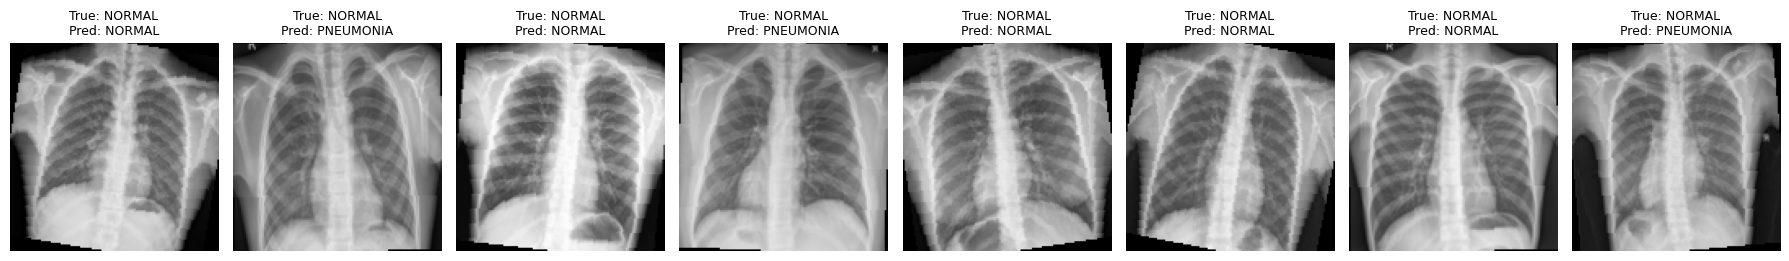

In [43]:
import matplotlib.pyplot as plt
import torch
import random

# Get a batch from test loader
model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Unnormalise images for display
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1).to(device)
images = images * std + mean

# Display 8 images
num_images = 8
indices = random.sample(range(len(images)), num_images)

# Plot
fig, axes = plt.subplots(1, num_images, figsize=(18, 3))
for i, idx in enumerate(indices):
    img = images[idx].permute(1, 2, 0).cpu()
    true_label = test_loader.dataset.classes[labels[idx].item()]
    pred_label = test_loader.dataset.classes[preds[idx].item()]
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
    ax.axis("off")
plt.tight_layout()